# Model API Example

In this notebook, we'll explore some functionality of the models of this package. We'll work with the coupled  CemaneigeGR4j model that is implemented in `rrmpg.models` module. The data we'll use, comes from the CAMELS [1] data set. For some basins, the data is provided within this Python library and can be easily imported using the `CAMELSLoader` class implemented in the `rrmpg.data` module.

In summary we'll look at:
- How you can create a model instance.
- How we can use the CAMELSLoader.
- How you can fit the model parameters to observed discharge by:
    - Using one of SciPy's global optimizer
    - Monte-Carlo-Simulation
- How you can use a fitted model to calculate the simulated discharge.


[1] Addor, N., A.J. Newman, N. Mizukami, and M.P. Clark, 2017: The CAMELS data set: catchment attributes and meteorology for large-sample studies. version 2.0. Boulder, CO: UCAR/NCAR. doi:10.5065/D6G73C3Q

In [1]:
# Imports and Notebook setup
from timeit import timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rrmpg.models import CemaneigeGR4J
from rrmpg.data import CAMELSLoader
from rrmpg.tools.monte_carlo import monte_carlo
from rrmpg.utils.metrics import calc_nse

# Let plots appear in the notebook
%matplotlib inline

## Create a model

As a first step let us have a look how we can create one of the models implemented in `rrmpg.models`. Basically, for all models we have two different options:
1. Initialize a model **without** specific model parameters.
2. Initialize a model **with** specific model parameters.

The [documentation](http://rrmpg.readthedocs.io) provides a list of all model parameters. Alternatively we can look at `help()` for the model (e.g. `help(CemaneigeGR4J)`).

If no specific model parameters are provided upon intialization, random parameters will be generated that are in between the default parameter bounds. We can look at these bounds by calling `.get_param_bounds()` method on the model object and check the current parameter values by calling `.get_params()` method.

For now we don't know any specific parameter values, so we'll create one with random parameters.

In [2]:
model = CemaneigeGR4J()
model.get_params()

{'CTG': 0.3359861769122866,
 'Kf': 0.8149823070907103,
 'x1': 292.97760019180146,
 'x2': -0.37480712839221475,
 'x3': 110.92666991189834,
 'x4': 2.5884480400725574}

Here we can see the six model parameters of CemaneigeGR4J model and their current values.

## Using the CAMELSLoader
To have data to start with, we can use the `CAMELSLoader` class to load data of provided basins from the CAMELS dataset. To get a list of all available basins that are provided within this library, we can use the `.get_basin_numbers()` method. For now we will use the provided basin number `01031500`.

In [3]:
df = CAMELSLoader().load_basin('01031500')
df.head()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa),PET,QObs(mm/d)
1980-10-01,41050.80,0.00,286.90,0.0,16.19,4.31,825.78,1.5713,0.5550
1980-10-02,40780.81,2.08,195.94,0.0,13.46,5.72,920.18,1.2619,0.4979
1980-10-03,40435.21,5.57,172.60,0.0,17.84,8.61,1128.70,1.2979,0.5169
1980-10-04,40435.21,23.68,170.45,0.0,16.28,7.32,1027.91,1.2251,1.5634
1980-10-05,40089.58,3.00,113.83,0.0,10.51,5.01,881.61,0.9116,2.8541


Next we will split the data into a calibration period, which we will use to find a set of good model parameters, and a validation period, we will use the see how good our model works on unseen data. As in the CAMELS data set publication, we will use the first 15 hydrological years for calibration. The rest of the data will be used for validation.

Because the index of the dataframe is in pandas Datetime format, we can easily split the dataframe into two parts

In [4]:
# calcute the end date of the calibration period
end_cal = pd.to_datetime(f"{df.index[0].year + 15}/09/30", yearfirst=True)

# validation period starts one day later
start_val = end_cal + pd.DateOffset(days=1)

# split the data into two parts
cal = df[:end_cal].copy()
val = df[start_val:].copy()

## Fit the model to observed discharge

As already said above, we'll look at two different methods implemented in this library:
1. Using one of SciPy's global optimizer
2. Monte-Carlo-Simulation

### Using one of SciPy's global optimizer

Each model has a `.fit()` method. This function uses the global optimizer [differential evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) from the scipy package to find the set of model parameters that produce the best simulation, regarding the provided observed discharge array.
The inputs for this function can be found in the [documentation](http://rrmpg.readthedocs.io) or the `help()`.

In [5]:
help(model.fit)

Help on method fit in module rrmpg.models.cemaneigegr4j:

fit(obs, prec, mean_temp, min_temp, max_temp, etp, met_station_height, snow_pack_init=0, thermal_state_init=0, s_init=0, r_init=0, altitudes=[]) method of rrmpg.models.cemaneigegr4j.CemaneigeGR4J instance
    Fit the Cemaneige + GR4J coupled model to a observed timeseries
    
    This functions uses scipy's global optimizer (differential evolution)
    to find a good set of parameters for the model, so that the observed 
    timeseries is simulated as good as possible.        
    
    Args:
        obs: Array of the observed timeseries [mm]
        prec: Array of daily precipitation sum [mm]
        mean_temp: Array of the mean temperature [C]
        min_temp: Array of the minimum temperature [C]
        max_temp: Array of the maximum temperature [C]
        etp: Array of mean potential evapotranspiration [mm]
        met_station_height: Height of the meteorological station [m]. 
            Needed to calculate the fraction o

We don't know any values for the initial states of the storages, so we will ignore them for now. For the missing mean temperature, we calculate a proxy from the minimum and maximum daily temperature. The station height can be retrieved from the `CAMELSLoader` class via the `.get_station_height()` method.

In [6]:
# calculate mean temp for calibration and validation period
cal['tmean'] = (cal['tmin(C)'] + cal['tmax(C)']) / 2
val['tmean'] = (val['tmin(C)'] + val['tmax(C)']) / 2

# load the gauge station height
height = CAMELSLoader().get_station_height('01031500')

Now we are ready to fit the model and retrieve a good set of model parameters from the optimizer. Again, this will be done with the calibration data. Because the model methods also except pandas Series, we can call the function as follows.

In [7]:
# We don't have an initial value for the snow storage,  so we omit this input
result = model.fit(cal['QObs(mm/d)'], cal['prcp(mm/day)'], cal['tmean'], 
                   cal['tmin(C)'], cal['tmax(C)'], cal['PET'], height)

`result` is an object defined by the scipy library and contains the optimized model parameters, as well as some more information on the optimization process. Let us have a look at this object:

In [8]:
result

     fun: 1.644224043927522
     jac: array([ 0.00000000e+00,  6.66133815e-07,  2.84217094e-05,  2.22044605e-08,
       -4.06341627e-06,  7.25827531e-01])
 message: 'Optimization terminated successfully.'
    nfev: 2709
     nit: 27
 success: True
       x: array([8.82518831e-02, 4.22529374e+00, 1.46933625e+02, 1.14411338e+00,
       5.84770150e+01, 1.10000000e+00])

The relevant information here is:
- `fun` is the final value of our optimization criterion (the mean-squared-error in this case)
- `message` describes the cause of the optimization termination
- `nfev` is the number of model simulations
- `sucess` is a flag wether or not the optimization was successful
- `x` are the optimized model parameters

Next, let us set the model parameters to the optimized ones found by the search. Therefore we need to create a dictonary containing one key for each model parameter and as the corresponding value the optimized parameter. As mentioned before, the list of model parameter names can be retrieved by the `model.get_parameter_names()` function. We can then create the needed dictonary by the following lines of code:

In [9]:
params = {}

param_names = model.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model.set_params(params)

# To be sure, let's look at the current model parameters
model.get_params()

{'CTG': 0.0882518831163816,
 'Kf': 4.225293735522786,
 'x1': 146.93362451505416,
 'x2': 1.1441133795720753,
 'x3': 58.47701495510382,
 'x4': 1.1}

Also it might not be clear at the first look, this are the same parameters as the ones specified in `result.x`. In `result.x` they are ordered according to the ordering of the `_param_list` specified in each model class, where ass the dictonary output here is alphabetically sorted.

### Monte-Carlo-Simulation

Now let us have a look how we can use the Monte-Carlo-Simulation implemented in `rrmpg.tools.monte_carlo`. 

In [10]:
help(monte_carlo)

Help on function monte_carlo in module rrmpg.tools.monte_carlo:

monte_carlo(model, num, qobs=None, **kwargs)
    Perform Monte-Carlo-Simulation.
    
    This function performs a Monte-Carlo-Simulation for any given hydrological
    model of this repository.
    
    Args:
        model: Any instance of a hydrological model of this repository.
        num: Number of simulations.
        qobs: (optional) Array of observed streamflow.
        **kwargs: Keyword arguments, matching the inputs the model needs to
            perform a simulation (e.g. qobs, precipitation, temperature etc.).
            See help(model.simulate) for model input requirements.
    
    Returns:
        A dictonary containing the following two keys ['params', 'qsim']. The 
        key 'params' contains a numpy array with the model parameter of each 
        simulation. 'qsim' is a 2D numpy array with the simulated streamflow 
        for each simulation. If an array of observed streamflow is provided,
        on

As specified in the help text, all model inputs needed for a simulation must be provided as keyword arguments. The keywords need to match the names specified in the `model.simulate()` function. Let us create a new model instance and see how this works for the CemaneigeGR4J model.

In [11]:
model2 = CemaneigeGR4J()

# Let use run MC for 1000 runs, which is in the same range as the above optimizer
result_mc = monte_carlo(model2, num=10000, qobs=cal['QObs(mm/d)'], 
                        prec=cal['prcp(mm/day)'], mean_temp=cal['tmean'],
                        min_temp=cal['tmin(C)'], max_temp=cal['tmax(C)'],
                        etp=cal['PET'], met_station_height=height)

# Get the index of the best fit (smallest mean squared error)
idx = np.argmin(result_mc['mse'][~np.isnan(result_mc['mse'])])

# Get the optimal parameters and set them as model parameters
optim_params = result_mc['params'][idx]

params = {}

for i, param in enumerate(param_names):
    params[param] = optim_params[i]

# This line set the model parameters to the ones specified in the dict
model2.set_params(params)

## Calculate simulated discharge

We now have two models, optimized by different methods. Let's calculate the simulated streamflow of each model and compare the results! Each model has a `.simulate()` method, that returns the simulated discharge for the inputs we provide to this function.

In [12]:
# simulated discharge of the model optimized by the .fit() function
val['qsim_fit'] = model.simulate(val['prcp(mm/day)'], val['tmean'], 
                                 val['tmin(C)'], val['tmax(C)'], 
                                 val['PET'], height)

# simulated discharge of the model optimized by monte-carlo-sim
val['qsim_mc'] = model2.simulate(val['prcp(mm/day)'], val['tmean'], 
                                 val['tmin(C)'], val['tmax(C)'], 
                                 val['PET'], height)

# Calculate and print the Nash-Sutcliff-Efficiency for both simulations
nse_fit = calc_nse(val['QObs(mm/d)'], val['qsim_fit'])
nse_mc = calc_nse(val['QObs(mm/d)'], val['qsim_mc'])

print("NSE of the .fit() optimization: {:.4f}".format(nse_fit))
print("NSE of the Monte-Carlo-Simulation: {:.4f}".format(nse_mc))

NSE of the .fit() optimization: 0.8078
NSE of the Monte-Carlo-Simulation: 0.7373


What do this number mean? Let us have a look at some window of the simulated timeseries and compare them to the observed discharge:

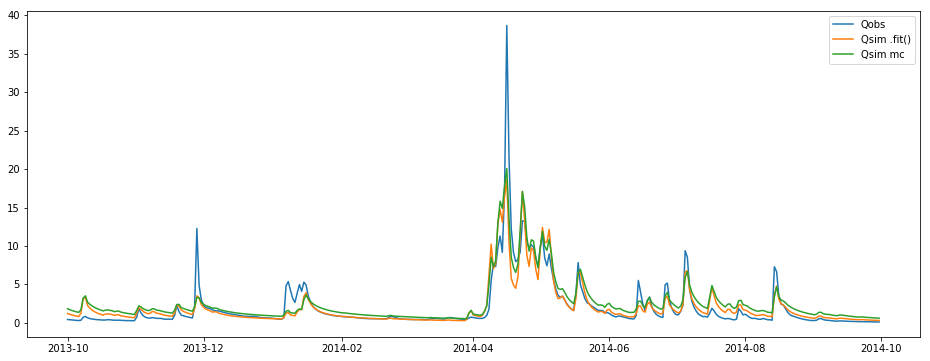

In [14]:
# Plot last full hydrological year of the simulation
start_date = pd.to_datetime("2013/10/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.figure(figsize=(16,6))
plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Qobs')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Qsim .fit()')
plt.plot(val.loc[start_date:end_date, 'qsim_mc'], label='Qsim mc')
plt.legend()

The result is not perfect, but it is not bad either! And since this package is also about speed, let us also check how long it takes to simulate the discharge for the entire validation period (19 years of data).

In [15]:
%%timeit 
model.simulate(val['prcp(mm/day)'], val['tmean'], 
                                 val['tmin(C)'], val['tmax(C)'], 
                                 val['PET'], height)

2.85 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
